# Información General:
- Autor: Javier Meitín Moreno
- ID: JDLA10
- Título: Reconocimiento de emociones a partir de voz (Shallow ANN)
- Director(es): Javier De Lope Asiaín


# 1. Installs

In [ ]:
!pip install tensorflow
#IMAGEN
!pip install librosa numpy matplotlib scikit-image
#IMPORTANCIA CARACTERISTICAS
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=192e92a12e058291b23a557b85bb3f637af2cc327f9b33c727707f8687258075
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


#2. Imports

In [ ]:
import random
import os # Cargar archivos wav e iterar sobre ellos
import librosa # Convertir .WAV a IMG
import librosa.display # Convertir .WAV a IMG
import matplotlib.pyplot as plt
import numpy as np
import cv2 # interpolacion para alargar la imagen
import seaborn as sns #matriz

from scipy.ndimage import zoom # Reducir la dimensionalidad de las imágenes
from skimage import io, color, exposure, transform #Cargar png
#Red Neuronal:
import pickle #guardar/cargar history de un archivo
import tensorflow as tf
from tensorflow.keras.models import load_model #Guardar/cargar model de un archivo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
#IMPORTANCIA Gradient Boosting
import xgboost as xgb

#3. Montar Google Drive

In [ ]:
# Google file system
from google.colab import drive
drive.mount('/GoogleDrive', force_remount=True)

RUTA = "/GoogleDrive/My Drive/Colab Notebooks/datasets/"
RUTA_WAV = RUTA + "RAVDESS_Audio_Speech/"
RUTA_IMG = RUTA + "RAVDESS_Audio_Speech_Img/"

Mounted at /GoogleDrive


#4. Preparar y procesar los datos
No todos los audios miden lo mismo. No solo varía la longitud de la frase, sino el silencio antes y después de la oración. Por estos motivos, hay que transformar los datos.

## 4.1. Método auxiliar para que eliminar los silencios:
- Necesitamos quitar el silencio al principio y al final del audio.
- El silencio se refleja con el pixel a negro (-80)

In [ ]:
UMBRAL_SILENCIO = -80  # Umbral para considerar una columna como silencio

def delete_silence(img):
  # Encuentra los índices del primer y último tiempo donde no hay silencio
  inicio_voz = np.argmax(np.any(img > UMBRAL_SILENCIO, axis=0))
  fin_voz = len(img[0]) - np.argmax(np.any(img[:, ::-1] > UMBRAL_SILENCIO, axis=0)[::-1])

  # Recorta el espectrograma para eliminar el silencio al principio y al final
  new_img = img[:, inicio_voz:fin_voz]

  return new_img

## 4.2. Método auxiliar para redimensionar una imagen:
- Todos los espectogramas tienen 1025 pixels de alto, pero el ancho oscila (143, 135, 167, etc).
- Esto es debido a que no todos los audios duran lo mismo.
- Para la ANN, necesitamos que todas las imágenes sean iguales.
- Además, también es útil hacer las imágenes más pequeñas con el fin de que haya menos características durante el entrenamiento.


In [ ]:
def resize_img(img, new_width = 66, new_height = 150):
    new_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return new_img

##4.3. Método auxiliar para pintar un espectograma:

In [ ]:
def plt_espectograma(img, sr):
  # Visualizar el espectrograma
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(img, sr=sr, x_axis='time', y_axis='log')
  plt.axis('on')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()

  print("Dimensiones: ", img.shape)
  plt.show()

  plt.close() # Importante para que sea más eficiente al ejecutar en bucle.

## 4.4. Convertir un archivo WAV a Espectograma
Para facilitar que la red neuronal aprenda los archivos de audio, los transformamos previamente a espectogramas. Así solo tenemos que gestionar imágenes.

**1) Calcular el espectograma: Anwer SLIMI (2021) usan los mismos parametros que Promod Yenigalla (2018)!!!**

- **"Although the resolution of frequencies is related to both the
window size and the sampling rate of the audio signal, J. Zhao et
al [13] and P. Yenigalla et al [14] used both the log Mel
spectrogram with the same parameters window size= 2048 and
overlap= 512 on different sampling rates. Anyhow, in our work,
we resampled all the data to 22050 Hz then we used the same
parameters in [13][14] to generate our spectrograms:"*
- n_fft=2048: Define la longitud de la ventana de la transformada de Fourier de tiempo corto (STFT) en 2048.
- hop_length=512: Define el tamaño del salto entre ventanas sucesivas de la STFT en 512.

**2) Transformar las imagenes:**
- **"The generated spectrograms for our SER system are represented
in RGBa color model where their length equals to 3600 pixels and
their width equals to 2400 pixel."*
- Tras eliminar los silencios, necesitamos redimensionar las imagenes para que sean iguales.
- Realizando un estuvio previo, determinamos que el WIDTH medio de las imagenes es 140. Por este motivo, alargaremos/estrecharemos las imagenes mediante INTERPOLACION LINEAL para que sean todas de 140.
- REDUCCION DE CARACTERÍSTICAS: Una vez todas las imagenes son iguales, las hacemos más pequeñas para facilitar el aprendizaje.

In [ ]:
NEW_WIDTH = 2400
NEW_HEIGHT = 3600

def convert_wav_to_img(file_name, show_img = False):
  audio_file_path = RUTA_WAV + file_name + ".wav"#"03-01-01-01-01-01-01.wav"

  # Genererar el espectrograma ==> Promod Yenigalla (2018)
  y, sr = librosa.load(audio_file_path, sr=22050) # Resampleo a 22050 Hz
  espectrograma = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)#, n_mels=NEW_HEIGHT)#, fmax=8000)
  espectrograma_db = librosa.power_to_db(espectrograma, ref=np.max)

  # Si no nos limitamos al oido humano
  #y, sr = librosa.load(audio_file_path, sr=22050)
  #espectrograma_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

  # ELIMINAR SILENCIO
  espectograma_sin_ruido = delete_silence(espectrograma_db)

  # REDIMENSIONAR LA IMAGEN 3600x??? ==> 3600x2400
  espectrograma_ajustado = resize_img(espectograma_sin_ruido, 140, 128)

  espectrograma_reducido = zoom(espectrograma_ajustado, 0.7) # 128x140 ==> 90x98 = 8820 pixels
  #espectrograma_reducido = resize_img(espectograma_sin_ruido) # Por defecto lo pone a 150x66

  # Visualizar el espectrograma
  if show_img == True:
    print("=== Imagen Original ===")
    plt_espectograma(espectrograma_db, sr)
    print("=== Imagen sin silencio ===")
    plt_espectograma(espectograma_sin_ruido, sr)
    print("=== Imagen Reducida ===")
    plt_espectograma(espectrograma_reducido, sr)

  # GUARDAR IMAGEN
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(espectrograma_reducido, sr=sr, x_axis='time', y_axis='log')

  plt.axis('off') # Quitar bordes blancos/unidades de medida
  plt.savefig(RUTA_IMG + file_name + ".png", bbox_inches='tight', pad_inches=0)

  plt.close() # Importante para que sea más eficiente al ejecutar en bucle.

  return espectrograma_reducido, espectograma_sin_ruido.shape[1]

Ejemplo para comprobar como funciona:

=== Imagen Original ===
Dimensiones:  (128, 143)


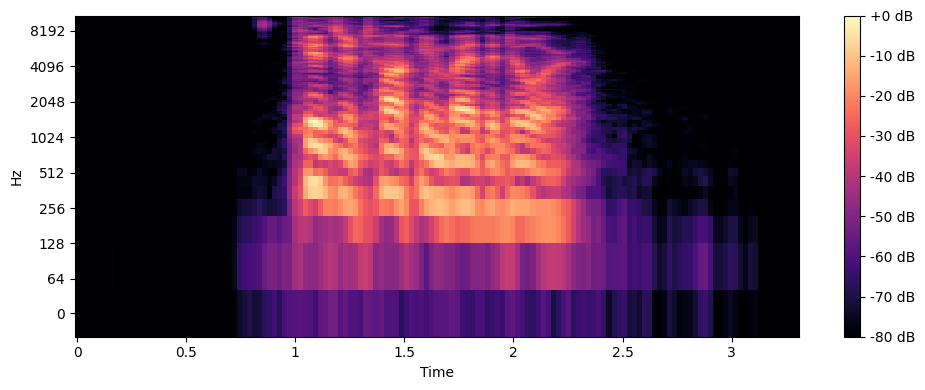

=== Imagen sin silencio ===
Dimensiones:  (128, 129)


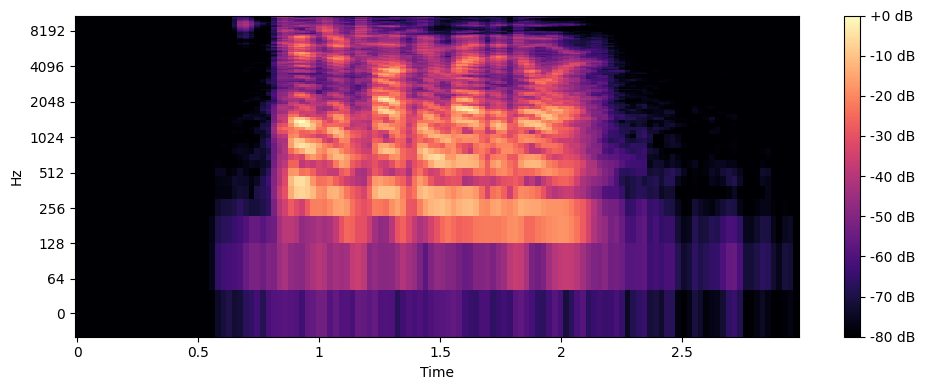

=== Imagen Reducida ===
Dimensiones:  (90, 98)


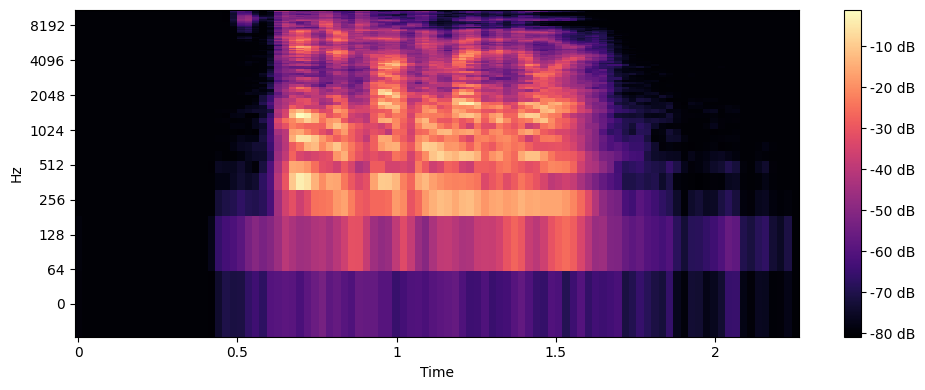

Emotion:  1


In [ ]:
file_name = "03-01-01-01-01-01-01"
convert_wav_to_img(file_name, show_img = True)
print("Emotion: ", file_name[7])

##4.6. Cargar los archivos y transormarlos a imágenes
**Filename identifiers:**
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = - fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
# Listar archivos en la carpeta
archivos_de_audio = [archivo for archivo in os.listdir(RUTA_WAV) if archivo.endswith(".wav")]

espectrogramas_lista = []
emociones_lista = []
widths_sin_ruido = []

# Procesar cada archivo de audio en un bucle
for archivo in archivos_de_audio:
  # Cargar el archivo de audio
  file_name = os.path.splitext(archivo)[0] # le quito el ".wav" al archivo.
  espectrograma, width_sin_ruido = convert_wav_to_img(file_name)
  emocion = file_name[7]

  espectrogramas_lista.append(espectrograma)
  emociones_lista.append(emocion)
  widths_sin_ruido.append(width_sin_ruido)

  if emocion == '1': #and random.random() <= 0.98:
    espectrogramas_lista.append(espectrograma)
    emociones_lista.append(emocion)
    widths_sin_ruido.append(width_sin_ruido)

X = np.array(espectrogramas_lista)
y = np.array(emociones_lista)

print(X.shape)
X = X.reshape(X.shape[0], -1)
print(X.shape)
print(y.shape)

(1543, 90, 98)
(1543, 8820)
(1543,)


Codigo auxiliar para estudiar la longitud de los audios.

In [ ]:
widths_sin_ruido_np = np.array(widths_sin_ruido)
widths_sin_ruido_np.sort()
print("Mediana: ", np.median(widths_sin_ruido_np))
print("Media: ", np.mean(widths_sin_ruido_np))

print (np.count_nonzero(y =='1'))
print (np.count_nonzero(y =='2'))
print (np.count_nonzero(y =='3'))
print (np.count_nonzero(y =='4'))
print (np.count_nonzero(y =='5'))
print (np.count_nonzero(y =='6'))
print (np.count_nonzero(y =='7'))

print(X.shape)
print(y.shape)

Mediana:  147.0
Media:  139.54439403758911
192
197
194
192
192
192
192
(1543, 9900)
(1543,)


In [ ]:
indices_no_neutrales = (y != 1).ravel() #There is no strong intensity for the 'neutral' emotion.
X = X[indices_no_neutrales] #quitamos esos casos
y = y[indices_no_neutrales]
print(X.shape)
print(y.shape)

(1351, 9900)
(1351,)


##4.7. Importancia Características
Métodos empleados para selecionar las características/pixels más importantes.

###4.7.1. Gradient Boosting:

In [ ]:
print (X.shape)
params = {
    'objective': 'multi:softmax',  # para clasificación multiclase
    'num_class': len(np.unique(y)), # número de clases
    'max_depth': 6,                 # profundidad máxima del árbol
    'learning_rate': 0.1,           # tasa de aprendizaje
    'n_estimators': 100,            # número de árboles
    'subsample': 0.8,               # proporción de muestras usadas para entrenar cada árbol
    'colsample_bytree': 0.8,        # proporción de características usadas para entrenar cada árbol
    'random_state': 42              # semilla aleatoria para reproducibilidad
}
y_int = y.astype(int) #necesita que sean ints

# Entrenar el clasificador XGBoost
model = xgb.XGBClassifier(**params)
model.fit(X, y_int - 1) # espera [0,7] en vez de [1,8]

# Obtener la importancia de las características
importances = model.feature_importances_

(1541, 8820)


###4.7.2. Importancias
Mostrar los 10 pixels más importantes.

In [ ]:
# Ordenar las importancias de las características de forma descendente
indices = np.argsort(importances)[::-1]

# Imprimir las características más importantes
print("Características más importantes:")
for i in range(10):  # Cambia esto al número deseado de características más importantes
    print(f"Feature {indices[i]}: Importance {importances[indices[i]]}")

Características más importantes:
Feature 553: Importance 0.0014299496656879414
Feature 173: Importance 0.0013706049448599029
Feature 168: Importance 0.0010852468087251153
Feature 534: Importance 0.0010026489406149426
Feature 175: Importance 0.0009891245228386735
Feature 548: Importance 0.0009754510826263263
Feature 550: Importance 0.0008742662328082703
Feature 163: Importance 0.0008663621449017998
Feature 383: Importance 0.000797924087741721
Feature 174: Importance 0.00073264667508195


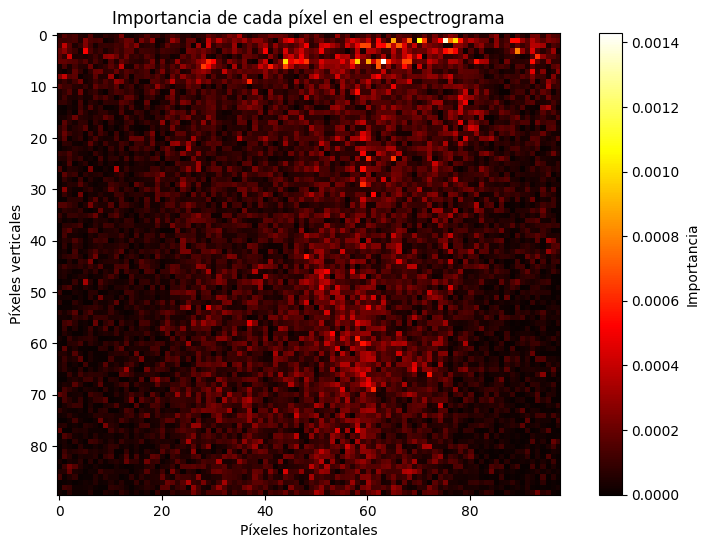

In [ ]:
# Reshape de las importancias para que coincida con la forma del espectrograma
importances_img = importances.reshape((90, 98))

# Crear la imagen de importancias
plt.figure(figsize=(10, 6))
plt.imshow(importances_img, cmap='hot', interpolation='nearest')
plt.colorbar(label='Importancia')
plt.title('Importancia de cada píxel en el espectrograma')
plt.xlabel('Píxeles horizontales')
plt.ylabel('Píxeles verticales')
plt.show()

###4.7.3. Filtrar pixels importantes

In [ ]:
indices_caracteristicas_importantes = np.where(importances > 0.00043)[0]
print(indices_caracteristicas_importantes.shape)
print("Índices de características importantes:", indices_caracteristicas_importantes)

(513,)
Índices de características importantes: [  51   67   68  101  128  129  148  173  175  178  185  189  191  204
  213  237  253  254  256  263  290  319  332  370  373  379  384  385
  411  416  417  436  438  457  459  460  462  483  488  499  515  516
  517  534  535  542  546  550  552  553  554  558  559  561  564  582
  598  602  617  706  748  757  763  780  781  825  832  843  859  863
  864  888  892  930  939  963  975  983 1058 1067 1072 1074 1075 1101
 1102 1133 1139 1194 1224 1229 1242 1270 1286 1298 1306 1312 1347 1365
 1378 1399 1448 1449 1450 1451 1480 1494 1495 1501 1533 1547 1548 1550
 1551 1552 1565 1580 1589 1591 1596 1598 1621 1637 1638 1641 1644 1680
 1734 1738 1739 1741 1756 1768 1811 1828 1862 1911 1920 1983 2002 2010
 2014 2037 2058 2084 2109 2118 2125 2127 2129 2144 2194 2195 2210 2285
 2326 2336 2401 2410 2414 2420 2429 2433 2455 2476 2487 2550 2567 2600
 2622 2627 2639 2657 2662 2671 2685 2707 2722 2746 2758 2808 2821 2843
 2847 2851 2887 2906 2911 2917

In [ ]:
# Eliminar las columnas con los índices de características importantes
X_filtrado = X[:, indices_caracteristicas_importantes]
print (X.shape)
print(X_filtrado.shape)

(1541, 8820)
(1541, 513)


##4.8. Guardar X e Y en un txt
Así solo tenemos que cargar los txt si queremos volver a ejecutar en vez de procesar otra vez todas las imágenes.

In [ ]:
RAV_X = "90x98/RAVDESS_x_TFM1_conNeutral2x.txt"
RAV_Y = "90x98/RAVDESS_y_TFM1_conNeutral2x.txt"

In [ ]:
X_numeric = X.astype(float) # savetxt peta si no porque X  contiene cadenas de texto (<U1) en vez de '%.18e'
np.savetxt(RUTA + RAV_X, X_numeric)
y_numeric = y.astype(int)
np.savetxt(RUTA + RAV_Y, y_numeric)

NameError: name 'X' is not defined

##4.9. Cargar X e Y ya procesado
Para ahorrar tiempo

In [ ]:
X = np.loadtxt(RUTA + RAV_X)
y = np.loadtxt(RUTA + RAV_Y)
print(X.shape)
print(y.shape)

(1541, 8820)
(1541,)


# 5. Red Neuronal
## 5.1. Preparar los conjuntos de datos para la red neuronal
- Primero normalizamos los datos, y codificamos las clases.
- Luego hacemos un split del conjunto de datos: 80% train, 10% validation, 10% test.

In [ ]:
# Normalización de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtrado) # X

# Codificación de etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
y_encoded = y_encoded.reshape(-1, 1)
y_onehot = onehot_encoder.fit_transform(y_encoded)

# División en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42) # 80%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 10, 10%
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1232, 8)
(154, 8)
(155, 8)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##5.2. Configurar el modelo:
Los hiperparámetros y optimizadores que emplea la ANN son los mismos que los planteados en el trabajo de Anwer Slimi (2020):
- **Referencia:** Anwer Slimi, Mohamed Hamroun, Mounir Zrigui and , Henri Nicolas. 2020. Emotion Recognition from Speech using Spectrograms and Shallow Neural Networks. The 18th International Conference on Advances in Mobile Computing & Multimedia (MoMM2020), November 30- December 2, 2020, Chiang Mai, Thailand. ACM, New York, NY, USA, 7 pages. https://doi.org/10.1145/3428690.3429153

La única diferencia son los parámetros HIDDEN_LAYER y EPOCHS, los cuales han sido optimizados.


In [ ]:
INPUT_LAYER = X_filtrado.shape[1] # X.shape[1]
HIDDEN_LAYER = 1500 # Originalmente 2000
LEARNING_RATE = 0.0001
DROPOUT = 0.5
EPOCHS = 200 # Originalmente 2600
BATCH_SIZE = 128
#Optimizador ADAM:
BETA_1 = 0.9
BETA_2 = 0.999

Usa el Optimizador Adam.

In [ ]:
# Configurar modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(HIDDEN_LAYER, input_dim=INPUT_LAYER, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Optimizador ADAM:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

##5.3. Entrenar el modelo

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/80
10/10 [==============================] - 5s 357ms/step - loss: 2.7950 - accuracy: 0.2159 - val_loss: 1.7976 - val_accuracy: 0.3831
Epoch 2/80
10/10 [==============================] - 2s 220ms/step - loss: 1.6437 - accuracy: 0.5154 - val_loss: 1.7451 - val_accuracy: 0.4286
Epoch 3/80
10/10 [==============================] - 3s 281ms/step - loss: 1.1902 - accuracy: 0.6080 - val_loss: 1.5088 - val_accuracy: 0.5390
Epoch 4/80
10/10 [==============================] - 2s 227ms/step - loss: 0.8720 - accuracy: 0.7070 - val_loss: 1.3881 - val_accuracy: 0.5714
Epoch 5/80
10/10 [==============================] - 2s 227ms/step - loss: 0.6557 - accuracy: 0.7849 - val_loss: 1.3844 - val_accuracy: 0.5519
Epoch 6/80
10/10 [==============================] - 4s 363ms/step - loss: 0.4893 - accuracy: 0.8336 - val_loss: 1.3652 - val_accuracy: 0.5455
Epoch 7/80
10/10 [==============================] - 3s 258ms/step - loss: 0.4187 - accuracy: 0.8709 - val_loss: 1.2790 - val_accuracy: 0.5909
Epoch 

##Guardar History y Model en un archivo

In [ ]:
history_file = RUTA + "history_slimi_TFM5_con1x2.pkl"
model_file = RUTA + "modelo_slimi_TFM5_con1x2.h5"

In [ ]:
#HISTORY
if os.path.exists(history_file):
  with open(history_file, 'wb') as file:
    pickle.dump(history.history, file)
else:
  with open(history_file, 'xb') as file: #x ==> crear archivo si no existe, b ==> archivo binario
    # Operaciones de escritura en el archivo
    pickle.dump(history.history, file)

# MODEL
model.save(model_file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
with open(history_file, 'rb') as file:
    loaded_history = pickle.load(file)

# Cargar el modelo desde el archivo
model = load_model(model_file)

## Ver History

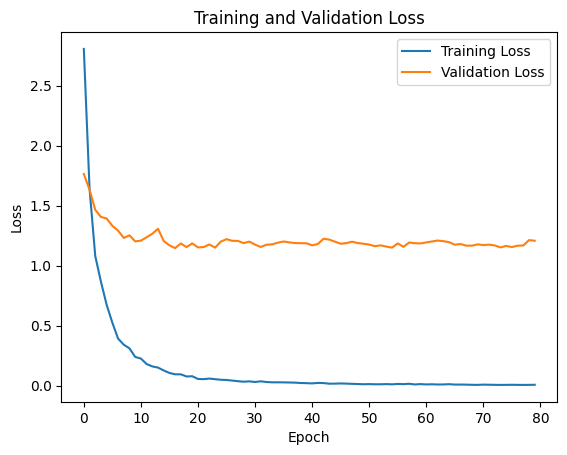

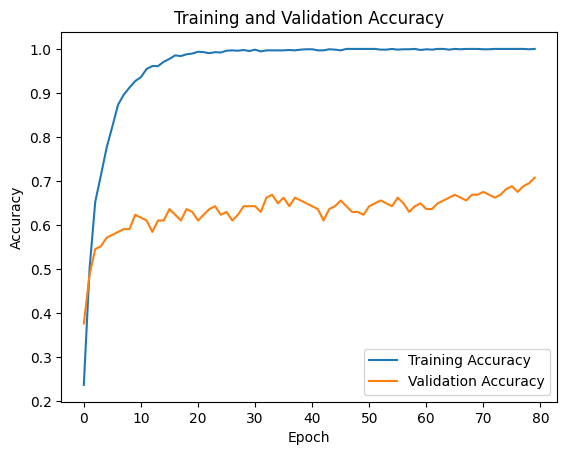

In [ ]:
# Visualizar la pérdida
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizar la precisión
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##5.4. Evaluación del modelo

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

5/5 [==============================] - 0s 61ms/step - loss: 1.1322 - accuracy: 0.6387
Loss: 1.132227897644043, Accuracy: 0.6387096643447876


##5.5. Predecir

5/5 [==============================] - 0s 31ms/step
Confusion Matrix:
[[22  0  0  0  0  0  0  1]
 [ 2 20  1  3  1  0  1  1]
 [ 2  0 11  0  0  2  1  3]
 [ 2  1  0  7  2  0  1  1]
 [ 0  2  1  0 14  1  2  2]
 [ 0  1  2  1  0  8  3  1]
 [ 1  1  1  3  0  1  8  3]
 [ 0  0  1  1  2  1  0  9]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.76      0.96      0.85        23
       Calma       0.80      0.69      0.74        29
   Felicidad       0.65      0.58      0.61        19
    Tristeza       0.47      0.50      0.48        14
       Enojo       0.74      0.64      0.68        22
       Miedo       0.62      0.50      0.55        16
    Disgusto       0.50      0.44      0.47        18
    Sorpresa       0.43      0.64      0.51        14

    accuracy                           0.64       155
   macro avg       0.62      0.62      0.61       155
weighted avg       0.65      0.64      0.64       155



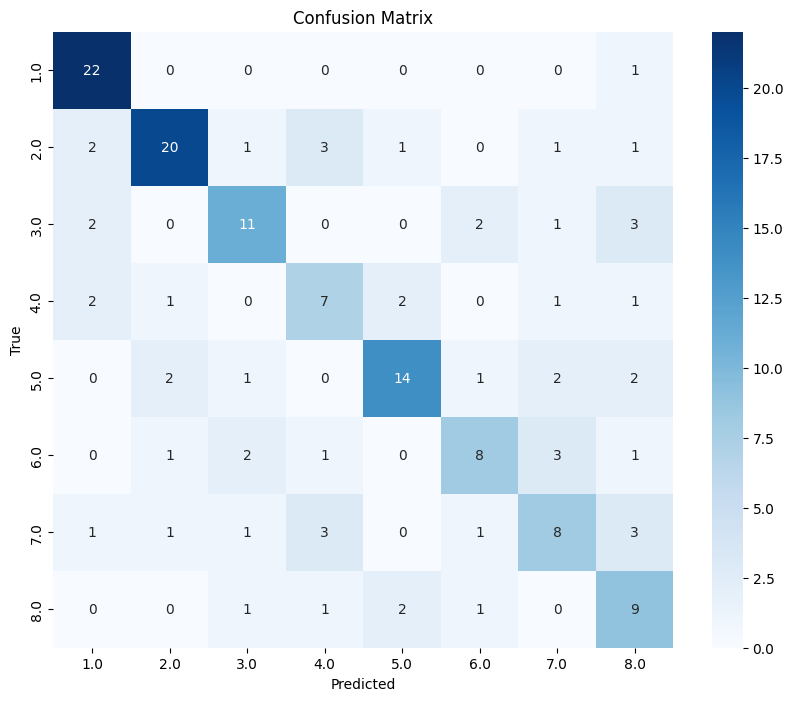

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

#01 = neutral, 02 = calma, 03 = felicidad, 04 = tristeza, 05 = enojo, 06= miedo, 07 = disgusto, 08 = sorpresa
class_names = ['Neutral', 'Calma', 'Felicidad', 'Tristeza', 'Enojo', 'Miedo', 'Disgusto', 'Sorpresa']

# Reporte de clasificación
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()